In [ ]:
# redo generator and discriminator architecture

In [ ]:
# !pip install scikit-image
# !pip install scipy

In [5]:
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from IPython import display
from tensorflow.data import Dataset

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Flatten, LeakyReLU, Conv2D, Conv2DTranspose, Concatenate

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.inception_v3 import InceptionV3
from skimage.transform import resize

In [2]:
sns.set(rc={'figure.dpi': 120})
sns.set_style('whitegrid')

In [3]:
# set gpu memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# set random seed
tf.random.set_seed(42)

## Load Dataset

In [5]:
FILE_PATH = 'data\cifar10.tfrecords'
dataset = Dataset.load(FILE_PATH)
print(dataset.element_spec)

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))


## Conditional Wasserstein Generative Adversarial Network w/ Gradient Penalty (cWGAN-GP)

### Defining Generator

In [6]:
# create conditional generator
def create_generator(latent_dim):
    # foundation for label embeedded input
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    # linear activation
    label_embedding = Dense(4 * 4, activation='linear', name='label_dense')(label_embedding)
    # reshape to additional channel
    label_embedding = Reshape((4, 4, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 4, 4, 1)

    # foundation for 4x4 image input
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    noise_dense = Dense(4 * 4 * 128, activation='linear', name='noise_dense')(noise_input)
    activation = LeakyReLU(alpha=0.2, name='noise_leakyrelu')(noise_dense)
    noise_reshape = Reshape((4, 4, 128), name='noise_reshape')(activation)
    assert noise_reshape.shape == (None, 4, 4, 128)

    # concatenate label embedding and image (generated) input 
    # to produce 129-channel output (latent_dim + 1)
    concat = Concatenate(name='concat')([noise_reshape, label_embedding])
    assert concat.shape == (None, 4, 4, 129)

    # upsample to 8x8
    conv1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv1')(concat)
    assert conv1.shape == (None, 8, 8, 128)
    activation = LeakyReLU(alpha=0.2, name='conv1_leakyrelu')(conv1)

    # upsample to 16x16
    conv2 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv2')(activation)
    assert conv2.shape == (None, 16, 16, 128)
    activation = LeakyReLU(alpha=0.2, name='conv2_leakyrelu')(conv2)

    # upsample to 32x32
    conv3 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', name='conv3')(activation)
    assert conv3.shape == (None, 32, 32, 128)
    activation = LeakyReLU(alpha=0.2, name='conv3_leakyrelu')(conv3)

    # output 32x32x3
    output = Conv2D(3, (3, 3), activation='tanh', padding='same', name='output')(activation)
    assert output.shape == (None, 32, 32, 3)

    # define model
    model = Model(inputs=[noise_input, label_input], outputs=output, name='generator')

    return model

In [7]:
generator = create_generator(latent_dim=128)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise_input (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 noise_dense (Dense)            (None, 2048)         264192      ['noise_input[0][0]']            
                                                                                                  
 label_embedding (Embedding)    (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                          

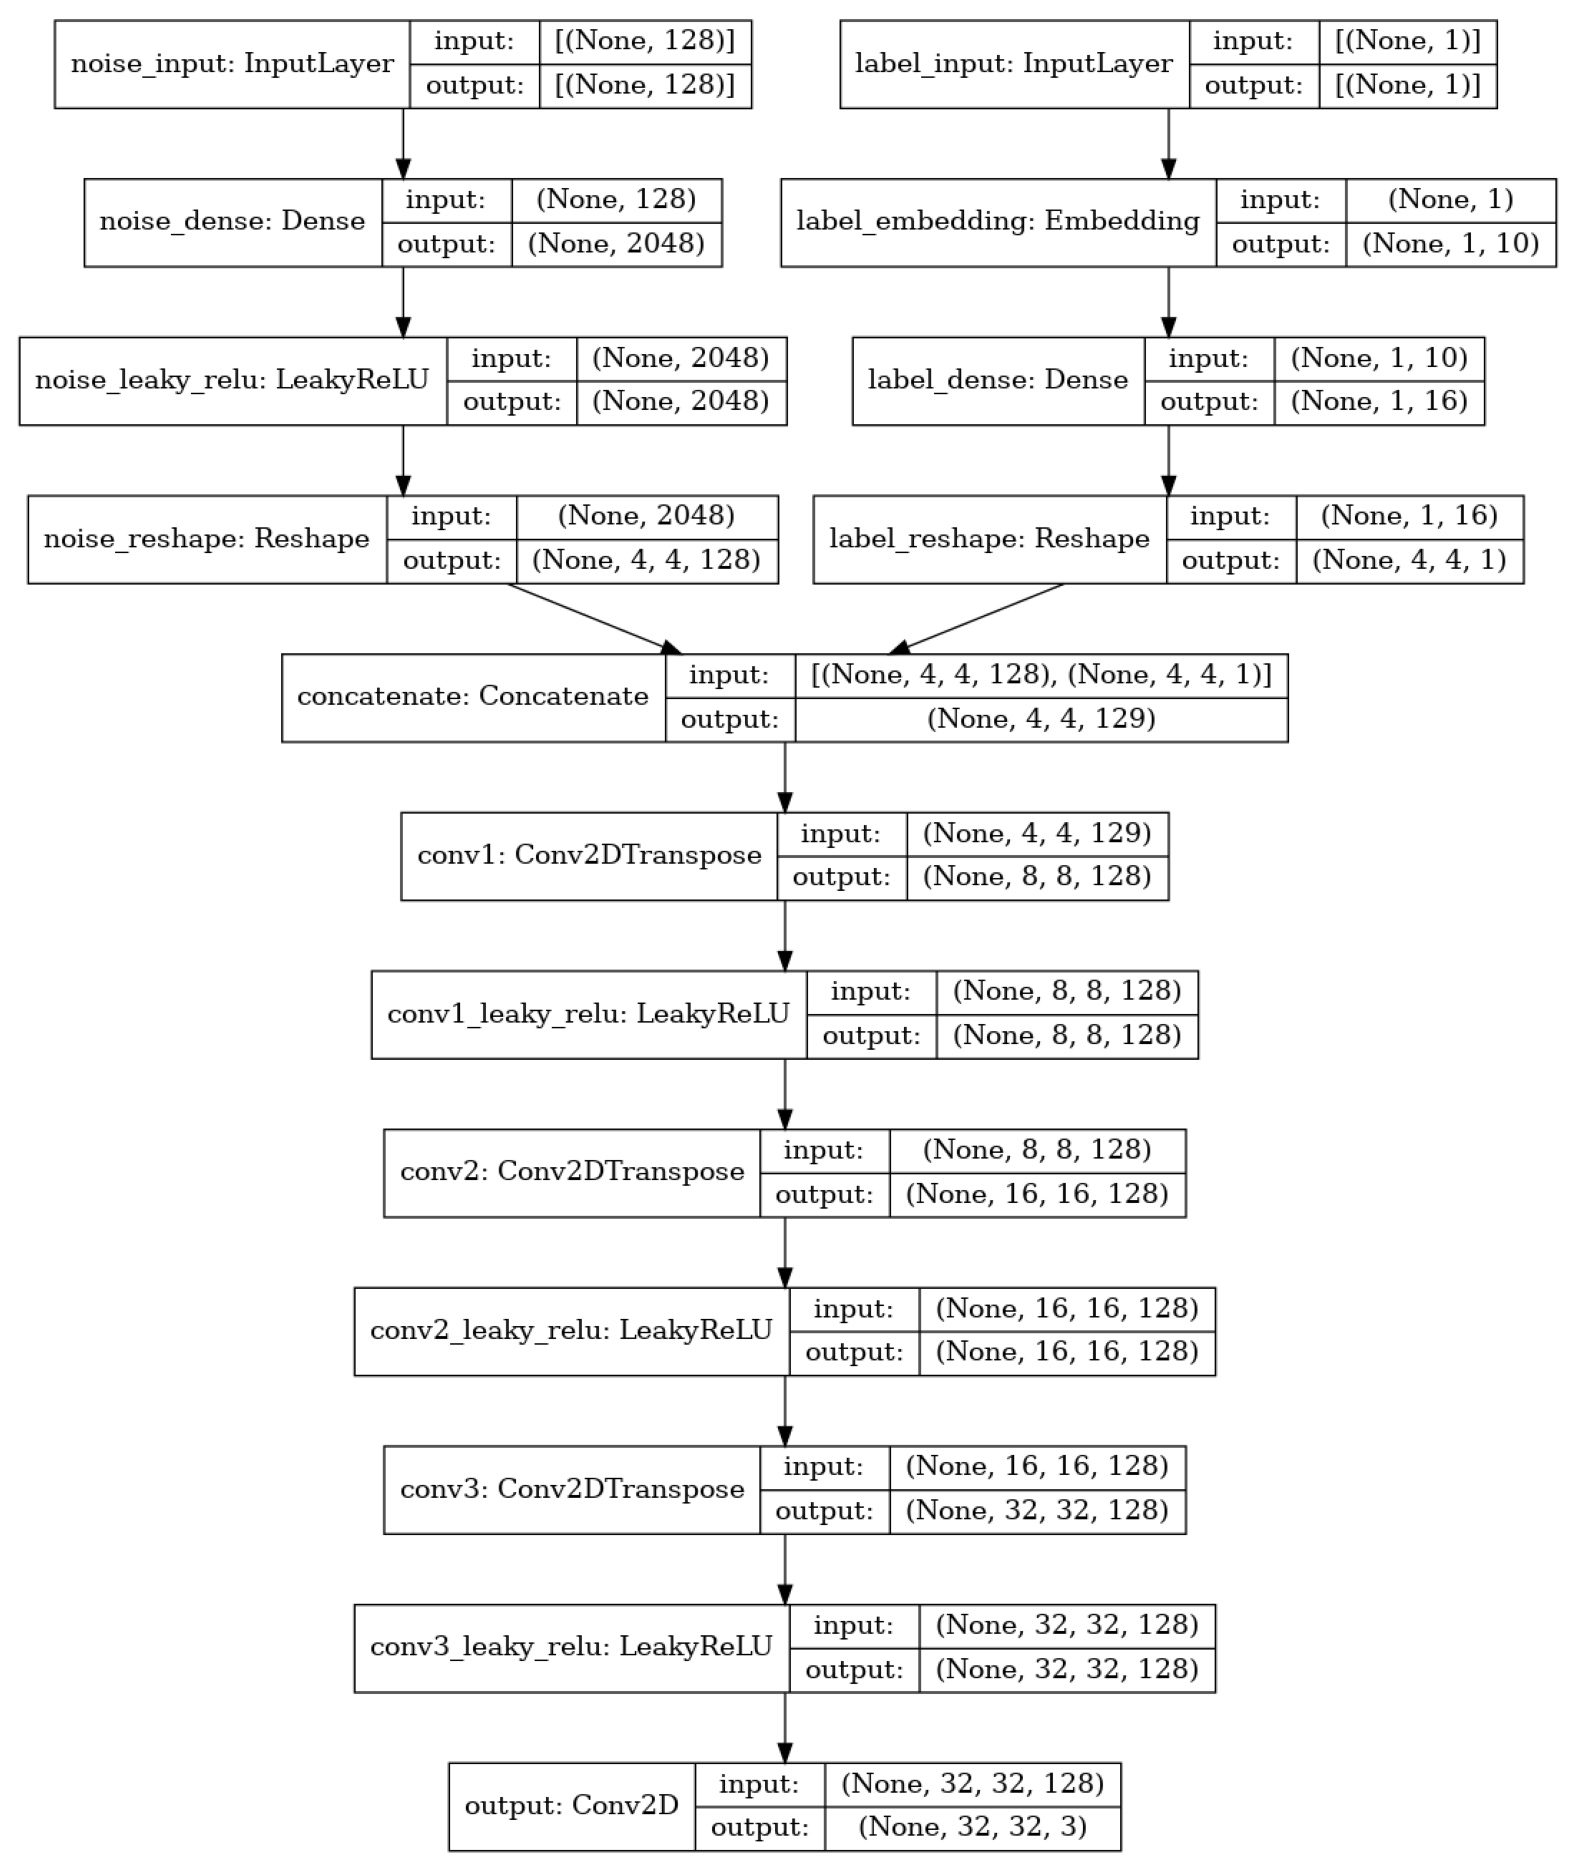

In [8]:
# visualize generator
# plot_model(generator, show_shapes=True, to_file='images\model_architecture\Conditional_WGAN\generator.png')
generator_img = mpimg.imread('images\model_architecture\Conditional_WGAN\generator.png')

plt.figure(figsize=(20, 20))
imgplot = plt.imshow(generator_img)
plt.axis('off')
plt.show()

### Defining Critic

In [9]:
# create conditional critic
def create_critic():
    # label embeded input
    label_input = Input(shape=(1,), name='label_input')
    label_embedding = Embedding(10, 10, name='label_embedding')(label_input)
    # linear activation
    label_embedding = Dense(32 * 32, activation='linear', name='label_dense')(label_embedding)
    # reshape to additional channel
    label_embedding = Reshape((32, 32, 1), name='label_reshape')(label_embedding)
    assert label_embedding.shape == (None, 32, 32, 1)

    # foundation for 32x32 image input
    image_input = Input(shape=(32, 32, 3), name='image_input')

    # concatenate label embedding and image input
    concat = Concatenate(name='concat')([image_input, label_embedding])
    assert concat.shape == (None, 32, 32, 4)

    # downsample to 16x16
    conv1 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv1')(concat)
    assert conv1.shape == (None, 16, 16, 128)
    activation = LeakyReLU(alpha=0.2, name='conv1_leakyrelu')(conv1)
    
    # downsample to 8x8
    conv2 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv2')(activation)
    assert conv2.shape == (None, 8, 8, 128)
    activation = LeakyReLU(alpha=0.2, name='conv2_leakyrelu')(conv2)

    # downsample to 4x4
    conv3 = Conv2D(128, kernel_size=3, strides=2, padding='same', name='conv3')(activation)
    assert conv3.shape == (None, 4, 4, 128)
    activation = LeakyReLU(alpha=0.2, name='conv3_leakyrelu')(conv3)

    # flatten feature maps
    flatten = Flatten(name='flatten')(activation)

    # output
    output = Dense(units=1, activation='linear', name='output')(flatten)

    # define model
    model = Model(inputs=[image_input, label_input], outputs=output, name='critic')

    return model

In [10]:
critic = create_critic()
critic.summary()

Model: "critic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 label_embedding (Embedding)    (None, 1, 10)        100         ['label_input[0][0]']            
                                                                                                  
 label_dense (Dense)            (None, 1, 1024)      11264       ['label_embedding[0][0]']        
                                                                                                  
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                             

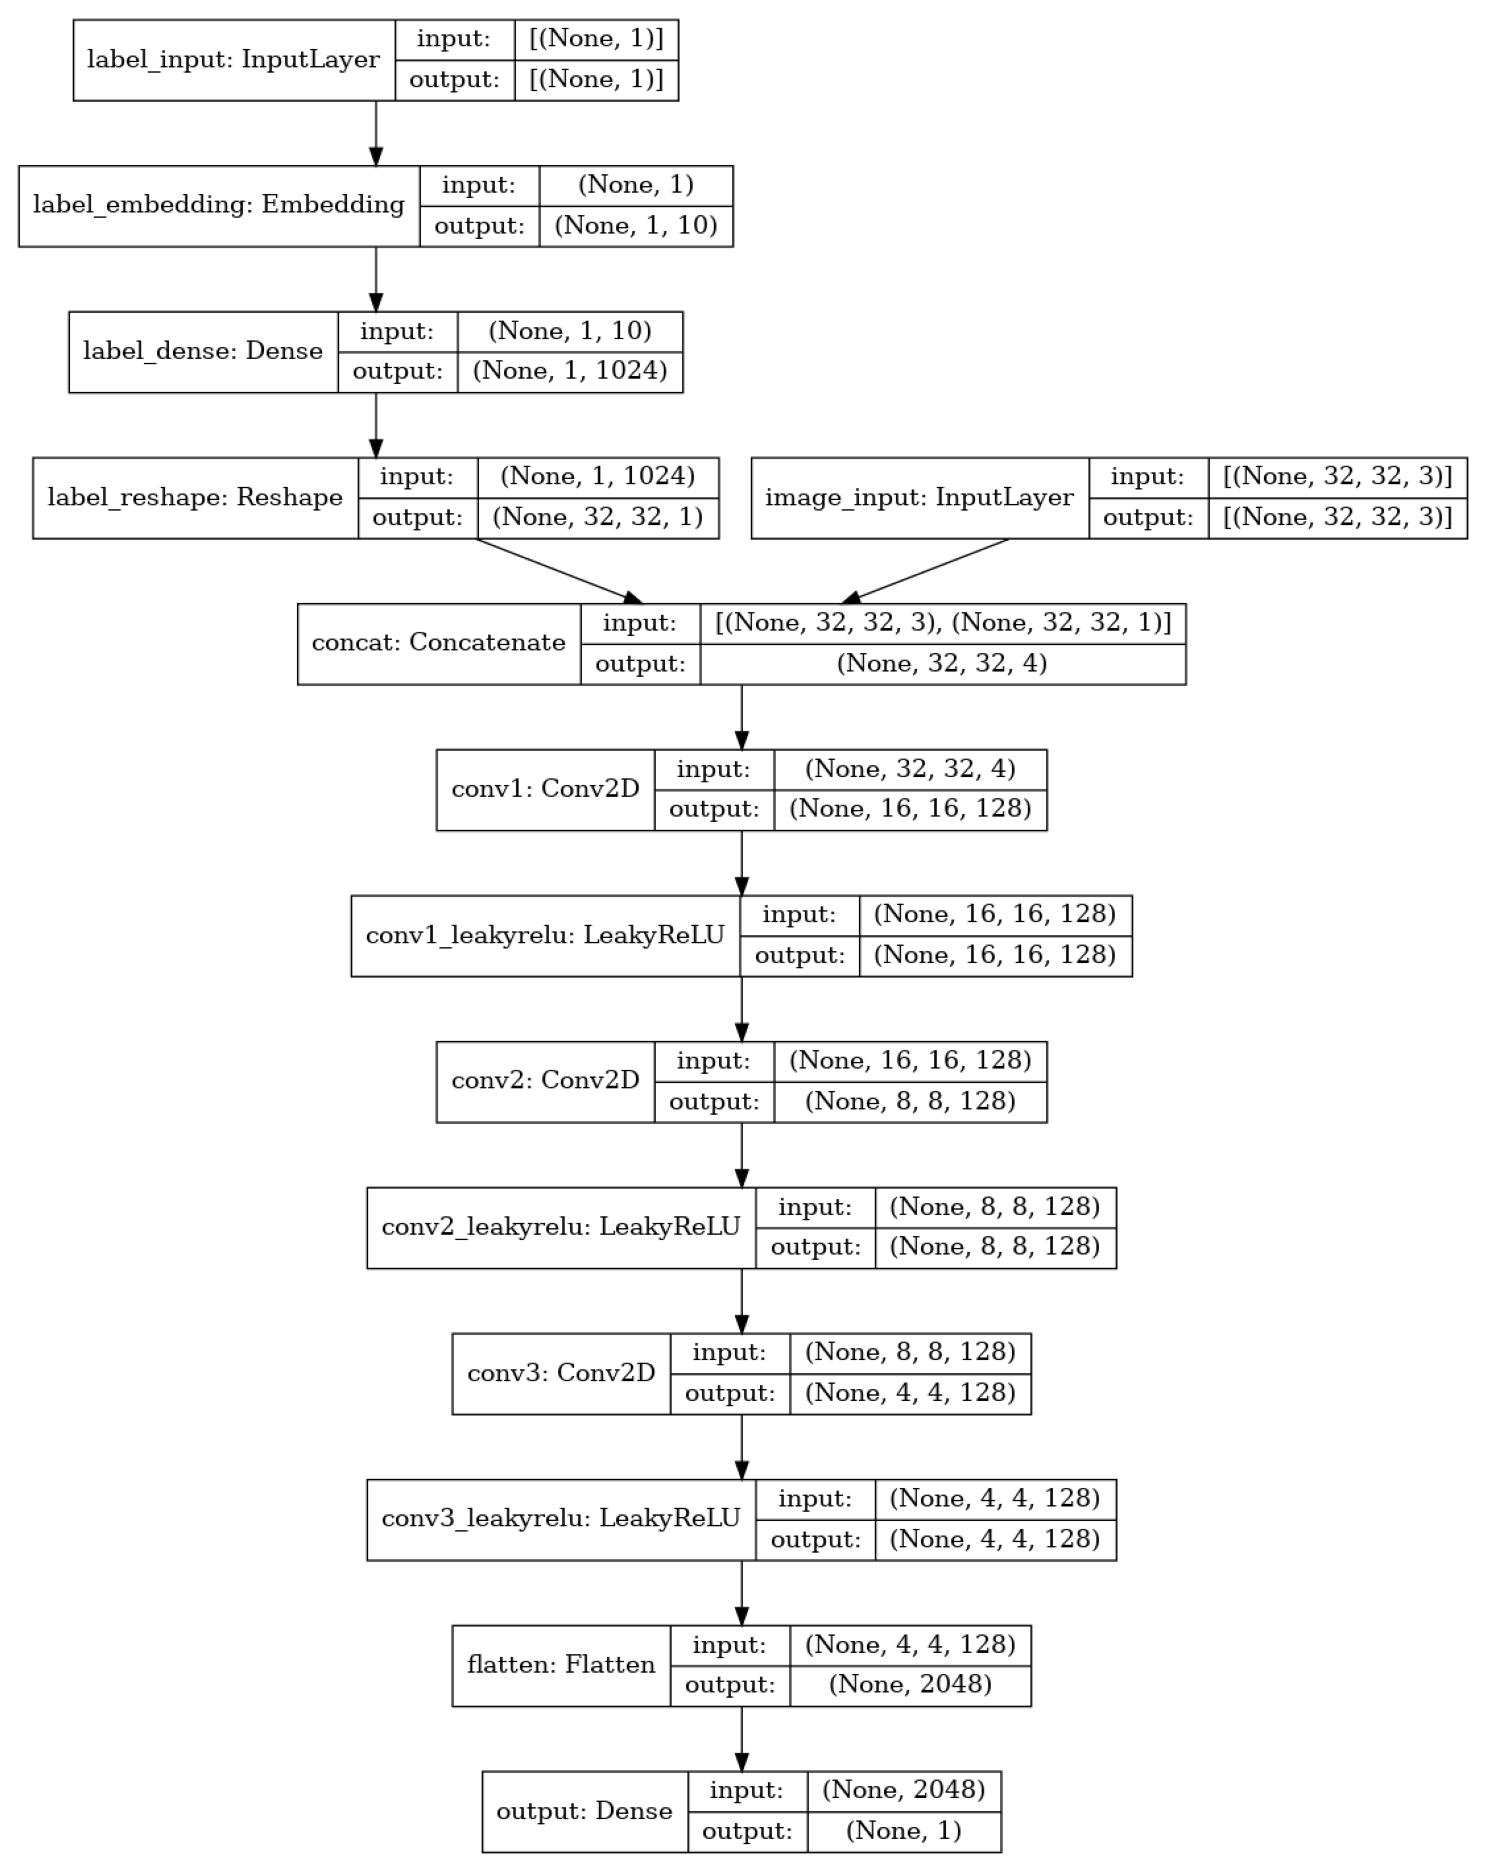

In [11]:
# visualize critic
# plot_model(critic, show_shapes=True, to_file='images\model_architecture\Conditional_WGAN\critic.png')
critic_img = mpimg.imread('images\model_architecture\Conditional_WGAN\critic.png')

plt.figure(figsize=(20, 20))
imgplot = plt.imshow(critic_img)
plt.axis('off')
plt.show()

### Defining WGAN-GP

In [12]:
class ConditionalWGAN(Model):
    def __init__(self, generator, critic, latent_dim, critic_steps, gp_coef):
        super(ConditionalWGAN, self).__init__()
        self.generator = generator
        self.critic = critic
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_coef = gp_coef

    def compile(self, g_optimizer, c_optimizer, g_loss_fn, c_loss_fn):
        super(ConditionalWGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
        self.g_loss_fn = g_loss_fn
        self.c_loss_fn = c_loss_fn
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')
        self.c_loss_metric = tf.keras.metrics.Mean(name='c_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.c_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        """
        Calculates the gradient penalty.
        This loss is calculated on an interpolated image.
        
        E[(||grad(D(x))|| - 1)^2]
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.critic([interpolated, labels], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)

        return gp

    def train_step(self, data):
        real_images, class_labels = data
        batch_size = tf.shape(real_images)[0]

        # train critic (train the critic more than the generator)
        for _ in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            random_class_labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=10, dtype='int32')

            # combined_class_labels
            with tf.GradientTape() as c_tape:
                generated_images = self.generator([random_latent_vectors, random_class_labels], training=True)
                fake_logits = self.critic([generated_images, random_class_labels], training=True)
                real_logits = self.critic([real_images, class_labels], training=True)
                # get critic loss with real and fake logits
                c_loss = self.c_loss_fn(real_logits, fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, generated_images, class_labels)  # ?????????
                # add gradient penalty to critic loss
                c_loss += self.gp_coef * gp  # E[D(x)] - E[D(G(z))] + λE[(||grad(D(x))|| - 1)^2]
            # get critic gradients
            c_grads = c_tape.gradient(c_loss, self.critic.trainable_weights)
            # update critic weights
            self.c_optimizer.apply_gradients(zip(c_grads, self.critic.trainable_weights))

        # train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_class_labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=10, dtype='int32')

        with tf.GradientTape() as g_tape:
            generated_images = self.generator([random_latent_vectors, random_class_labels], training=True)
            fake_logits = self.critic([generated_images, random_class_labels], training=True)
            # get generator loss
            g_loss = self.g_loss_fn(fake_logits)
        # get generator gradients
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
        # update generator weights
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))
        
        # update metrics
        self.g_loss_metric.update_state(g_loss)
        self.c_loss_metric.update_state(c_loss)

        return {
            'g_loss': self.g_loss_metric.result(), 
            'c_loss': self.c_loss_metric.result()
        }

### Defining Loss Functions

In [13]:
def critic_loss(real_logits, fake_logits):
    """
    Computes the critic loss.
    
    E[D(x)] - E[D(G(z))] 
    
    where D and G are the  critic and generator respectively.
    x is a real image and z is a random vector.
    """
    real_loss = tf.reduce_mean(real_logits)
    fake_loss = tf.reduce_mean(fake_logits)
    return fake_loss - real_loss 

def generator_loss(fake_logits):
    """
    Computes the generator loss.

    E[D(G(z))] 

    where D and G are the  critic and generator respectively.
    z is a random vector.
    """
    return -tf.reduce_mean(fake_logits)

### Defining Callback

In [14]:
class GANMonitor(Callback):
    def __init__(self, latent_dim, label_map):
        self.latent_dim = latent_dim
        self.label_map = label_map

    def on_epoch_end(self, epoch, logs=None):
        latent_vectors = tf.random.normal(shape=(100, self.latent_dim))
        class_labels = tf.reshape(tf.range(10), shape=(10, 1))
        class_labels = tf.tile(class_labels, multiples=(1, 10))
        class_labels = tf.reshape(class_labels, shape=(100, 1))

        generated_images = self.model.generator([latent_vectors, class_labels], training=False)
        generated_images = (generated_images + 1) / 2

        if not os.path.exists('images/cwgangp_images'):
            os.makedirs('images/cwgangp_images')

        # if epoch % 10 == 0:
        fig, axes = plt.subplots(10, 10, figsize=(20, 20))
        axes = axes.flatten()

        for i, ax in enumerate(axes):
            ax.imshow(generated_images[i])
            ax.set_title(self.label_map[class_labels[i].numpy().item()], fontsize=16)
            ax.axis('off')

        plt.tight_layout()
        plt.savefig(f'images/cwgangp_images/generated_img_{epoch}.png')
        plt.close()

## Training WGAN

In [15]:
EPOCHS = 1000

LATENT_DIM = 128
CRITIC_STEPS = 5
GP_COEF = 10

LEARNING_RATE = 2e-4
BETA_1 = 0.5
BETA_2 = 0.999

label_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

callbacks = [GANMonitor(LATENT_DIM, label_map)]

wgan = ConditionalWGAN(
    generator=create_generator(LATENT_DIM), 
    critic=create_critic(), 
    latent_dim=LATENT_DIM, 
    critic_steps=CRITIC_STEPS,
    gp_coef=GP_COEF
)

wgan.compile(
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2),
    c_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2),
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss
)

In [16]:
%%time
history = wgan.fit(dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
469/469 [==============================] - 162s 310ms/step - g_loss: 59.9359 - c_loss: -19.3371
Epoch 2/10
469/469 [==============================] - 144s 307ms/step - g_loss: 5.5158 - c_loss: -7.6993
Epoch 3/10
469/469 [==============================] - 146s 312ms/step - g_loss: -3.4900 - c_loss: -7.5675
Epoch 4/10
469/469 [==============================] - 143s 304ms/step - g_loss: -28.3925 - c_loss: -5.5379
Epoch 5/10
469/469 [==============================] - 143s 305ms/step - g_loss: -56.7331 - c_loss: -5.3231
Epoch 6/10
469/469 [==============================] - 143s 305ms/step - g_loss: -97.7820 - c_loss: -5.1116
Epoch 7/10
469/469 [==============================] - 141s 301ms/step - g_loss: -92.1109 - c_loss: -4.6881
Epoch 8/10
469/469 [==============================] - 143s 305ms/step - g_loss: -101.5530 - c_loss: -4.4007
Epoch 9/10
469/469 [==============================] - 141s 299ms/step - g_loss: -122.4446 - c_loss: -4.1404
Epoch 10/10
469/469 [=================

## Model Evaluation

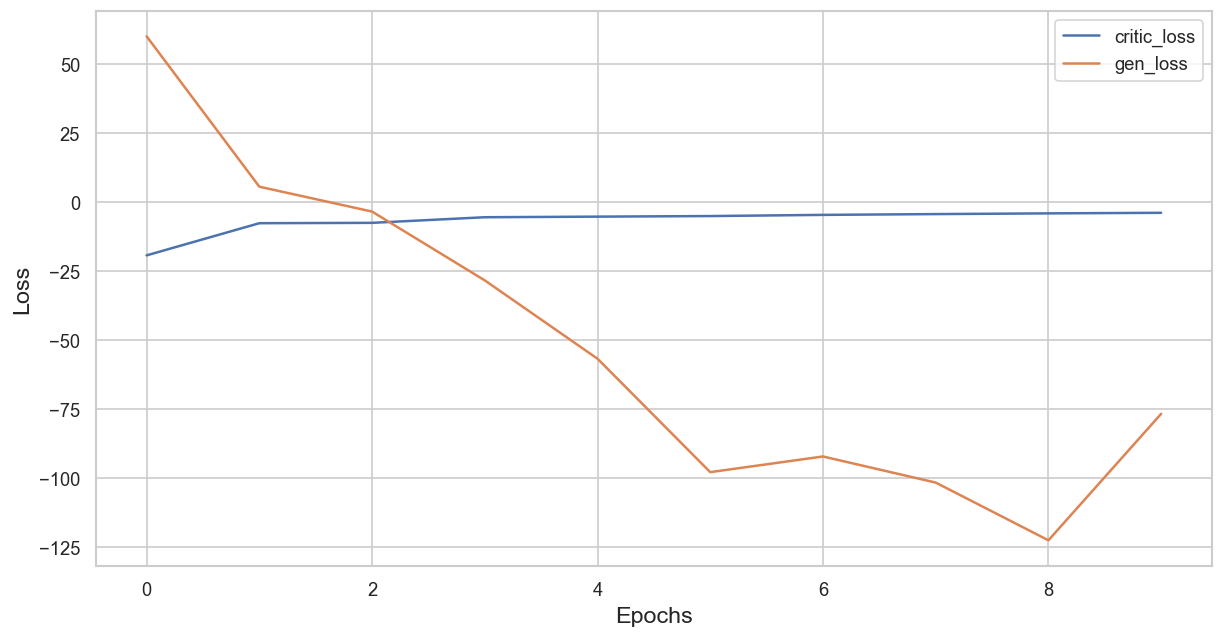

In [17]:
plt.figure(figsize=(12,6))
plt.plot(history.history['c_loss'], label='critic_loss')
plt.plot(history.history['g_loss'], label='gen_loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend()
plt.show()

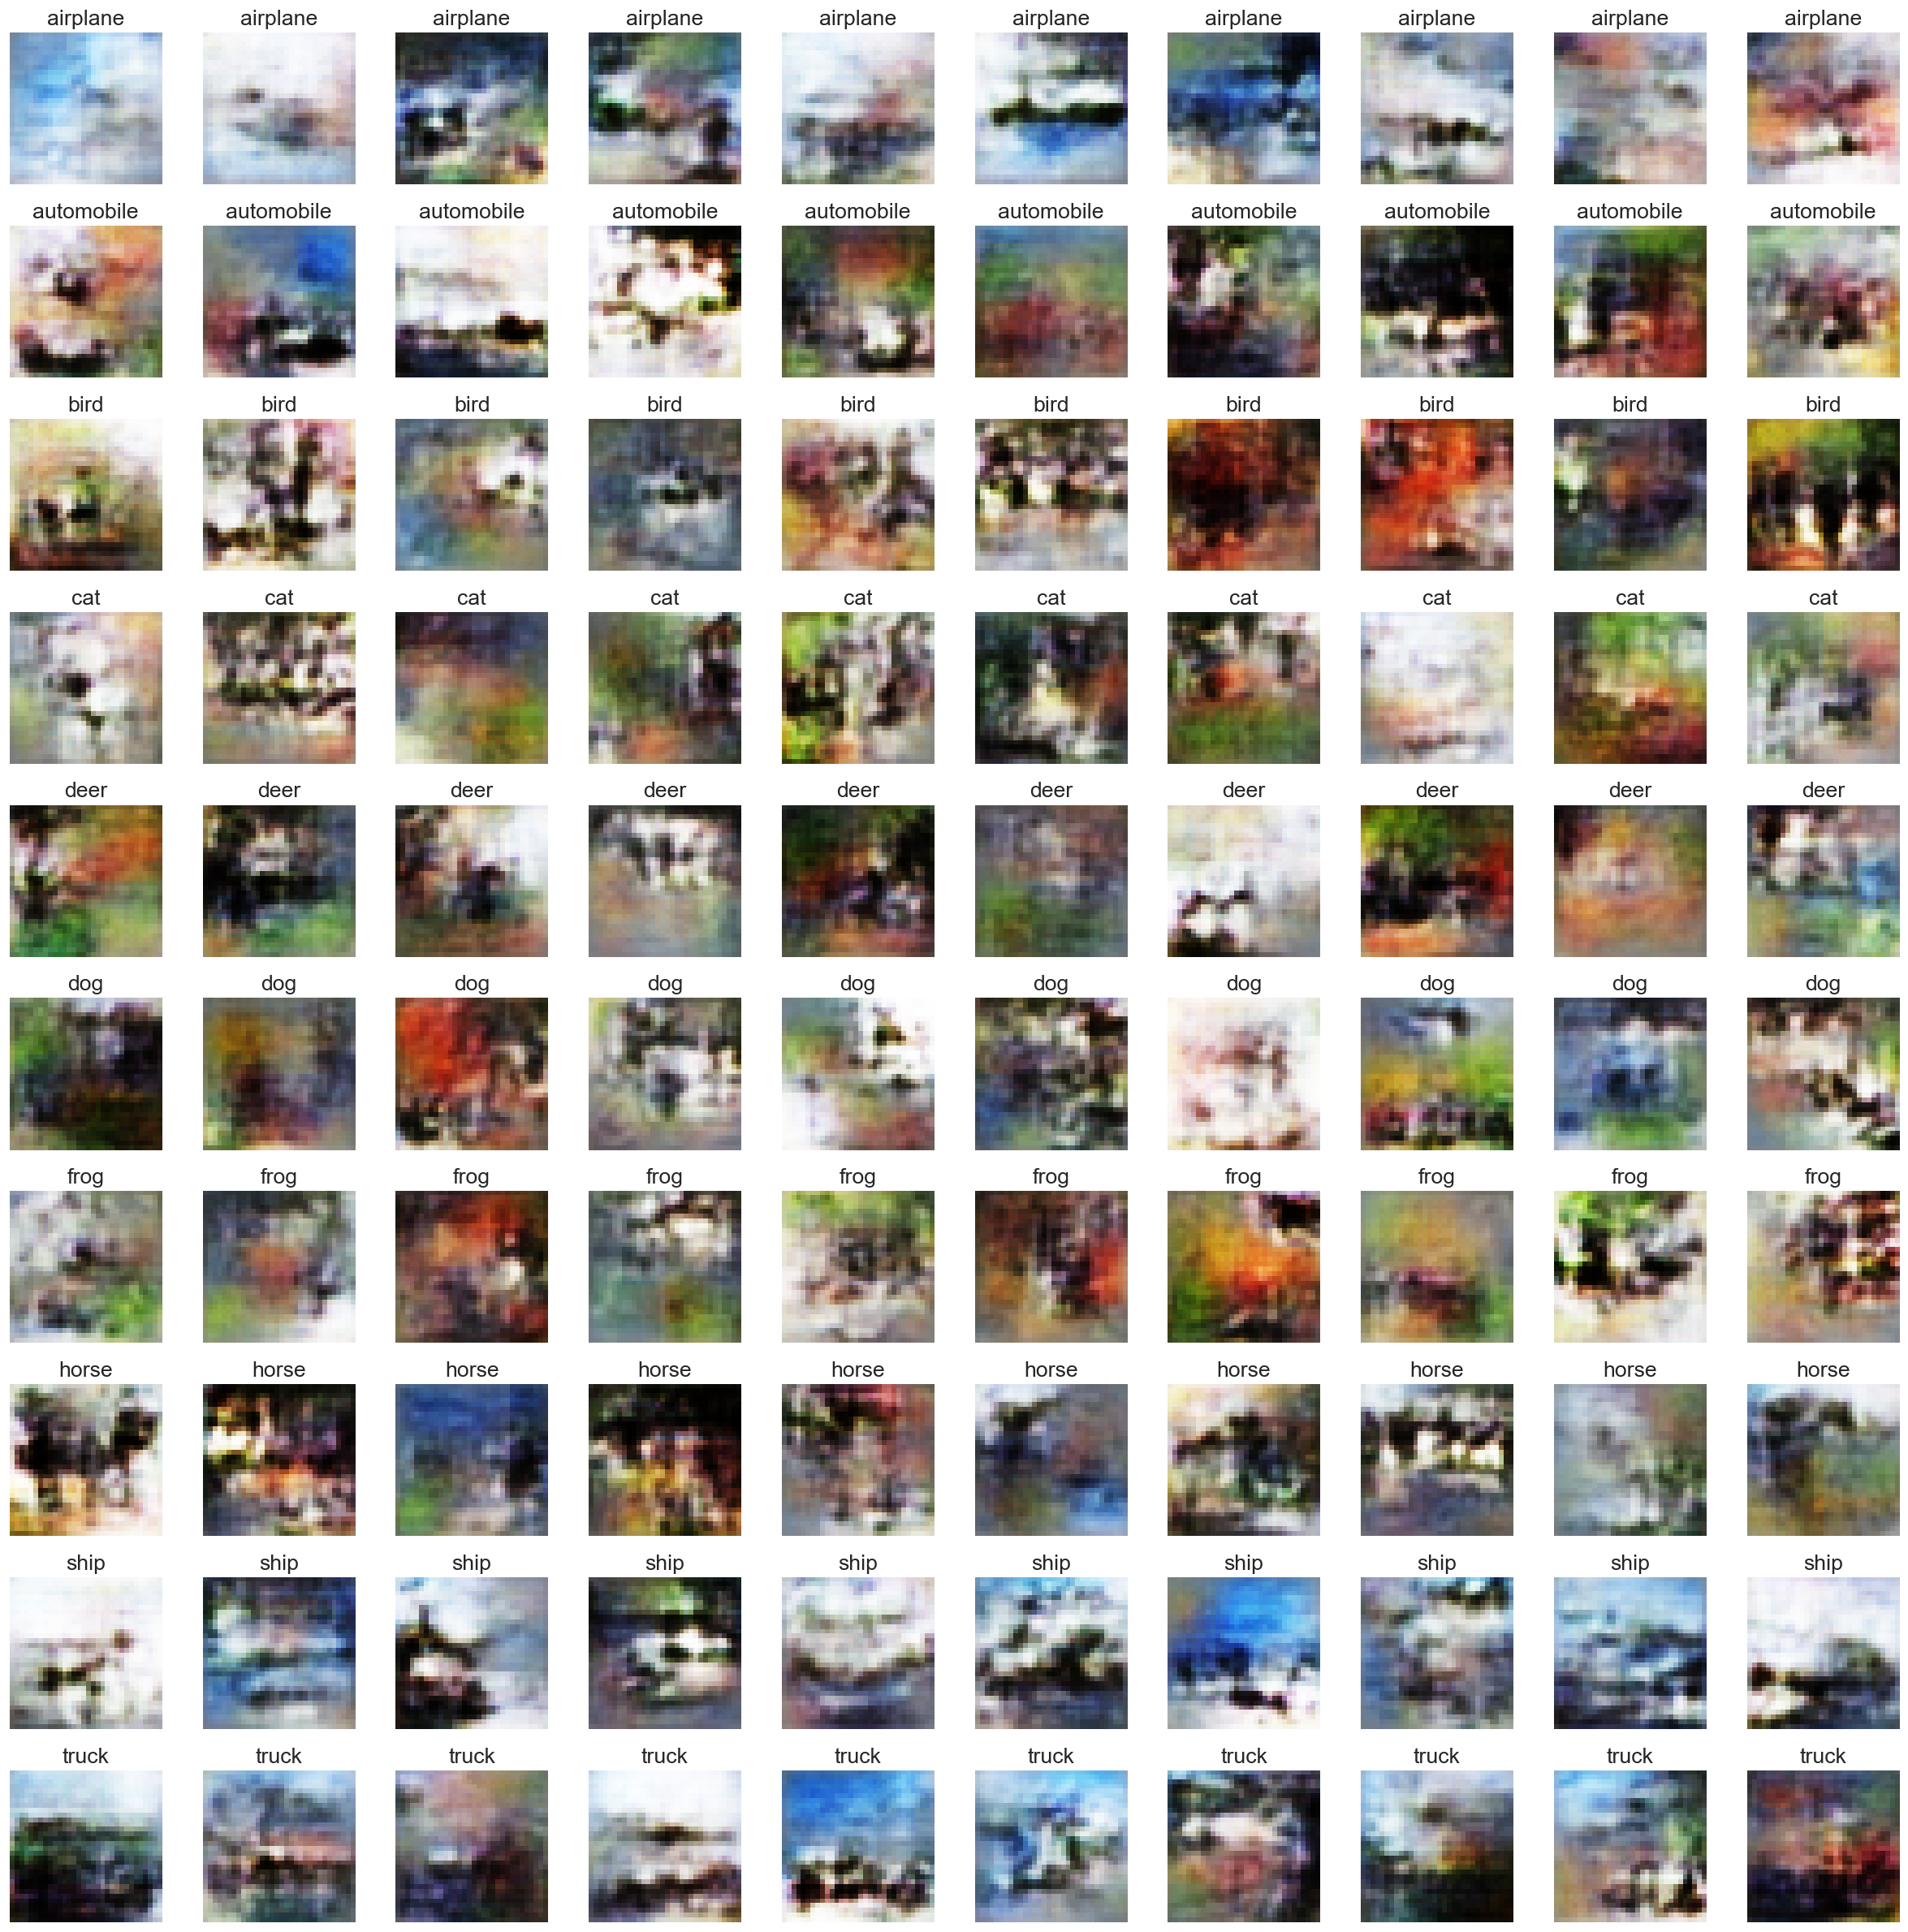

In [22]:
# test the generator
trained_generator = wgan.generator

latent_vectors = tf.random.normal(shape=(100, LATENT_DIM))
class_labels = tf.reshape(tf.range(10), shape=(10, 1))

class_labels = tf.tile(class_labels, multiples=(1, 10))
class_labels = tf.reshape(class_labels, shape=(100, 1))

generated_images = trained_generator([latent_vectors, class_labels], training=False)
generated_images = (generated_images + 1) / 2

fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(generated_images[i])
    ax.set_title(label_map[class_labels[i].numpy().item()], fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()

notes:

- wgan takes longer to train but is more stable
- could embed label information for conditional training